In [1]:
import os
import re

import numpy as np
import pandas as pd
import random
import scipy

import io
from datetime import datetime
import functools

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from PIL import Image
import matplotlib.offsetbox as offsetbox
import matplotlib.patches as patches
import imageio



In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2023-04-30 17:39:58.920077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.12.0


In [130]:
def load_cnn_data():
    def pull_height_width(string_in):
        """ Assumes a string containing something formatted like
        `6-18"`  OR  `1-3'`  OR  `15-20' x 6-10'`  OR  `Groundcover`
        """
        def pull_size(string_in):
            # Assume last character is either ' or "
            conversions = {"'": 1, '"': 1/12}
            string_in = string_in.strip()
            if '-' in string_in:
                x = np.mean([float(a) for a in re.split('-', string_in[:-1])])
            else:
                x = float(string_in[:-1])
            return x * conversions[string_in[-1]]
        if 'groundcover' in string_in.lower():
            return (0.5, 2)
        # Look for hw pattern
        # e.g.  3    - 5         '        x   1     - 2        "
        #      __  ________  ________  __________ _______   _________
        rx = r"\d+(?:\-\d+)?(?:[\'\"])(?: *x *\d+(?:\-\d+)?(?:[\'\"]))?"
        if not re.search(rx, string_in):
            return 0., 0.
        s = re.search(rx, string_in).group(0) 
        if 'x' in s:
            h, w = re.split('x', s)
        else:
            h, w = [s] * 2     
        return pull_size(h), pull_size(w)
    def pull_species_and_name(string_in, post_name_pattern):
        """Assumes a format like
        Genus species Common Name of Some Length post_name_pattern then whatever else doesn't matter
        """
        names_section = re.split(post_name_pattern, string_in.lower())[0]
        # Get first two space-separated substrings (Genus species)
        species = ' '.join(re.split(' ', names_section)[:2]).strip().capitalize()
        common_name = ' '.join(re.split(' ', names_section)[2:]).title().strip().replace("'S", "'s")
        return species, common_name
    def pull_arbitrary_pattern(pattern, string_in):
        return (re.findall(pattern, string_in.lower())[0] if re.search(pattern, string_in.lower()) else '').strip()
    def col_contains(df_col, string):
        return df_col.str.lower().str.contains(string)
    def pick_most_common_val(df, col):
        subset = df[df[col] != '']
        if subset.shape[0] == 0:
            return {col: ''}
        return {col: subset[col].value_counts().index[0]}
    def pick_truthiest(df, col):
        return {col: 1 <= df[col].sum()}

    moisture_options = ['dry', 'average', 'moist']
    light_options = ['sun', 'part shade', 'shade']

    # Load manually formatted data:
    # Columns: 
    #        Type       Light   Moisture   Species   Common Name   Height   Catskill Native?   Comments
    # e.g.   Perennial  Shade   Dry        Allium... Wild Onion    1-2'     No                 Pink flowers
    df = pd.read_csv('data/catskill_native_nursery0.csv')
    df0 = pd.DataFrame({
        'type': df['Type'],
        'species': df['Species'],
        'common_name': df['Common Name'],
    })
    df0['height'], df0['width'] = zip(*df['Height'].apply(lambda x: pull_height_width(x)))
    for col in moisture_options:
        df0[col] = df['Moisture'].str.lower() == col
    for col in light_options:
        df0[col] = df['Light'].str.lower() == col
    df0['if_catskill_native'] = df['Catskill Native?'] == 'Yes'
    df0['comments'] = df['Comments']

    # Load data - layout 1
    # Species Common name Height Catskill Native? Comments,Types
    # First five columns are not comma separated, so use the following patterns to parse
    # Species is almost always two words
    # Height is almost always of the format described in `get_height_width`
    # Catskill Native? is always of the format Yes or No
    df = pd.read_csv('data/catskill_native_nursery1.csv')
    df.columns = ['info', 'type']
    species, common_name = zip(*df['info'].apply(lambda x: pull_species_and_name(x, 'groundcover|\d')))
    
    height, width = zip(*df['info'].apply(lambda x: pull_height_width(x)))
    description = df['info'].apply(lambda x: re.split('No |Yes ', x)[-1].strip() if 1 < len(re.split('No |Yes ', x)) else '')
    df1 = pd.DataFrame({
        'type': '',
        'species': species,
        'common_name': common_name,
        'height': height,
        'width': width,
    })
    for col in moisture_options + light_options:
        df1[col] = col_contains(description, col)
    df1['sun'] = True; df1['dry'] = True; # List was for dry sun
    df1['if_catskill_native'] = df['info'].str.contains('Yes')
    df1['comments'] = description
    

    # Load data - layout 2 (all natives)
    # season, location, description
    # Description is not comma separated, so use the following patterns to parse
    # Each line is generally of the form
    #   Species Common-Name Form (h-w') Moisture; Light Description
    df = pd.read_csv('data/catskill_native_nursery2.csv')
    species, common_name = zip(*df['description'].apply(lambda x: pull_species_and_name(x, 'groundcover|[a-z]* \(')))
    df['form'] = df['description'].apply(lambda x: pull_arbitrary_pattern(r'([a-zA-Z]*)(?: \()', x))
    df.loc[df['description'].str.contains("Groundcover"), 'form'] = 'Groundcover'
    height, width = zip(*df['description'].apply(lambda x: pull_height_width(x)))
    comments = df['description'].apply(lambda x: pull_arbitrary_pattern(
        r'(?:; (?:part )?(?:[a-z]*)?(?: to |/)?(?:part )?(?:[a-z]*))([a-z ;&]+)', x 
    ))
    df2 = pd.DataFrame({
        'type': df['form'],
        'species': species,
        'common_name': common_name,
        'height': height,
        'width': width,
    })
    for col in moisture_options + light_options:
        df2[col] = col_contains(df['description'], col)
    df2.loc[df['location'] == 'woodland', 'shade'] = True
    df2.loc[df['location'] == 'sun', 'sun'] = True
    df2['if_catskill_native'] = ~col_contains(df['description'], 'not native')
    df2['comments'] = comments

    # e.g. Acer spicatum Mountain Maple Small tree (20') NE NA Some shade Upright flower spikes; Fall foliage
    df = pd.read_csv('data/catskill_native_nursery3.csv')
    species, common_name = zip(*df['info'].apply(lambda x: pull_species_and_name(x, 'groundcover|(small|medium|diminutive|large)? ?[a-z]* \(')))
    # common_name = common_name.apply(lambda x: pull_arbitrary_pattern(r'[a-zA-Z \']*(?: ?small|medium|diminutive|large)?'))
    type = df['info'].apply(lambda x: pull_arbitrary_pattern(r'([a-zA-Z]*)(?: \()', x))
    height, width = zip(*df['info'].apply(lambda x: pull_height_width(x)))
    if_native = df['info'].apply(lambda x: pull_arbitrary_pattern(r'\).*( se na | southeast | appalachians | atlantic | carolina )', x)) == ''
    df3 = pd.DataFrame({
        'type': type,
        'species': species,
        'common_name': common_name,
        'height': height,
        'width': width,
    })
    for col in moisture_options + light_options:
        df3[col] = col_contains(df['info'], col)
    inds = df['info'].str.lower().str.contains('adaptable')
    df3.loc[inds[inds].index, moisture_options] = True
    df3['if_catskill_native'] = if_native
    df3['comments'] = df['info'].apply(lambda x: pull_arbitrary_pattern(r'(?:\) (?:[a-z/;]* ){2})(?:.*(?:moist|dry|shade|sun))?;?(.*)', x))

    # Merge all the things!
    cnn = pd.concat((df0, df1, df2, df3), axis=0)
    species_counts = cnn['species'].value_counts()
    species_counts = species_counts[1 < species_counts].index
    res = cnn[~cnn['species'].isin(species_counts)].reset_index(drop=True)
    for species in species_counts:
        s = cnn[cnn['species'] == species]
        res = pd.concat((
            res, 
            pd.DataFrame({
                    **{k: v for col in ['type', 'species', 'common_name'] for k, v in pick_most_common_val(s, col).items()},
                    **{'height': s['height'].mean(), 'width': s['width'].mean()},
                    **{k: v for col in moisture_options + light_options + ['if_catskill_native'] for k, v in pick_most_common_val(s, col).items()},
                    'comments': '; '.join([str(ss) for ss in s['comments'].unique()])
                }, index=[res.shape[0]])
        ), axis=0)
    res['comments'] = res['comments'].fillna('-')
    res['diameter'] = res['width']
    res.loc[~res['dry'] & ~res['average'] & ~res['moist'], 'average'] = True
    res.loc[~res['sun'] & ~res['part shade'] & ~res['shade'], 'part shade'] = True
    res['colour'] = res['comments'].apply(lambda x: pull_arbitrary_pattern(
        r'(white|green|yellow|orange|red|pink|blue|purple)', x.lower()
        ))

    return res
    

In [59]:
def load_plant_list():
    df = pd.read_csv('data/plant_list.csv')
    df.drop(['Unnamed: 1', 'Unnamed: 15'], axis=1, inplace=True)
    df.columns = [c.lower() for c in df.columns]
    df = df.rename(columns={'spacing': 'diameter'})

    bool_cols = ['dry', 'medium', 'moist', 'sun', 'partial', 'shade', 'deer resistant']
    for col in bool_cols:
        b = pd.Series([False] * df.shape[0])
        b[df[col] == 'Y'] = True
        df[col] = b
    months = {
        mon: i + 3 for i, mon in enumerate(
            ['Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct']
            )
            }
    for k, v in months.items():
        df = df.replace(k, v)
    timecols = ['mintime', 'maxtime']
    for col in timecols: df[col] = pd.to_numeric(df[col])

    df['item'] = df['plant'].apply(lambda x: clean_str(x))
    df = df.set_index('item').drop(['dianthus', 'anemone'])
    df['height'] = df['maxheight']
    return df

def clean_str(s):
    return s.replace("'", '').replace(' ', '_').lower()

In [11]:
df = load_cnn_data()
old_df = load_plant_list()

In [61]:
PLANT_COLOURS_DICT = {
    'White': 'lightyellow',
    'Yellow': 'gold',
    'Pink': 'hotpink',
    'Blue': 'lightskyblue',
    'Lavender': 'plum',
    'Purple': 'darkviolet',
    'Green': 'lawngreen',
    'Red': 'crimson',
    'Orange': 'darkorange',
}
colours = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(colour)[:3])), name)
                for name, colour in colours.items())
COLOUR_NAMES = [name for hsv, name in by_hsv if (hsv[2] < 0.8) and (0.2 < hsv[2])]

def load_square_image(filename, size):
    img = Image.open(filename)
    img = img.resize((size, size))
    
    c = np.min(np.asarray(img).shape[:2])
    img = img.crop(((size - c) // 2, 0, c + (size - c) // 2, c))
    
    return img

def generate_circle(r, n_pts=100):
    theta = np.linspace(0, 2 * np.pi, n_pts).tolist()
    return [r * np.cos(th) for th in theta], [r * np.sin(th) for th in theta]

def generate_centred_circle(x, y, r):
    x_offset, y_offset = generate_circle(r)
    return [x + xi for xi in x_offset], [y + yi for yi in y_offset]

def plot_circle(x, y, r, ax):
    x_pts, y_pts = generate_centred_circle(x, y, r)
    ax.plot(x_pts, y_pts, 'k:', linewidth=1)
    ax.set(aspect='equal')

def plot_plan(items, xy, df_inventory, dims):
    f, ax = plt.subplots()
    for i, item in enumerate(items):
        plot_circle(xy[i, 0], xy[i, 1], df_inventory.loc[item]['diameter'] / 2, ax)
    ax.plot([0, dims[0], dims[0], 0, 0], [0, 0, dims[1], dims[1], 0], 'k--', linewidth=2)
    return f, ax

def plot_plant(plant, x, y, f, ax):
    df = load_plant_list()
    pts_per_screen_inch = 60
    screen_inches_per_image_foot = np.max(f.get_size_inches()) / np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
    
    pts_per_image_foot = 12 * 2.54 * 5
    plant_footprint = df.loc[plant]['diameter']
    imagebox = offsetbox.OffsetImage(
        load_square_image(f'cleaned_pics/{plant}.png', int(plant_footprint * pts_per_image_foot)),
        zoom = pts_per_screen_inch * screen_inches_per_image_foot / pts_per_image_foot * 0.9
    ) 
    ax.add_artist(offsetbox.AnnotationBbox(
        imagebox, (x, y), frameon = False
    ))
    plot_circle(x, y, plant_footprint / 2, ax)
    
def plot_garden_sideview(items, xy, width, figsize_x):
    df = load_plant_list()

    height = df.loc[list(items)]['height'].max()
    inds = np.argsort(xy[:, 1])[::-1]
    f, ax = plt.subplots(figsize=(figsize_x, figsize_x * height/width))
    ax.set(xlim=[0, width], ylim=[0, height], aspect='equal')
    plt.axis('off')
    f.tight_layout()
    for i in inds:
        plant_info = df.loc[items[i]]
        ax.add_patch(patches.Rectangle(
            (xy[i, 0] - plant_info['diameter'] / 2, 0), 
            plant_info['diameter'], plant_info['height'],
            facecolor=PLANT_COLOURS_DICT[plant_info['colour']], edgecolor=[0.3] * 3, alpha=0.7,
            ))

def plot_garden_base(dims, figsize):
    width, height = dims
    f, ax = plt.subplots(1, 1, figsize=(figsize * width/height, figsize))
    ax.set(xlim=[0, width], ylim=[0, height], aspect='equal')
    plt.axis('off')
    f.tight_layout()
    return f, ax

def plot_plan(items, xy, df_inventory, dims):
    f, ax = plt.subplots()
    for i, item in enumerate(items):
        plot_circle(xy[i, 0], xy[i, 1], df_inventory.loc[item]['diameter'] / 2, ax)
    ax.plot([0, dims[0], dims[0], 0, 0], [0, 0, dims[1], dims[1], 0], 'k--', linewidth=2)
    return f, ax

def scatter_heights(items, xy, df_inventory, dims, figsize=4):
    f, ax = plot_garden_base(dims, figsize)
    # pts are 1/72 inch, i.e. 72pt/plot".  given fs plot"/1 plot, 1 plot/dims[1] real feet, 
    # i.e. 72*fs/dims[1] pts/real foot
    ax.scatter(
        xy[:,0], xy[:, 1], 
        s = (
            (72 * figsize / dims[1]) ** 2
            * np.pi * (df_inventory.loc[list(items)]['diameter'].values / 2) ** 2
        ),
        c = df_inventory.loc[list(items)]['height'].values,
        cmap=sns.color_palette('flare', as_cmap=True))
    return f, ax

def plot_garden(items, xy, df_inventory, dims, figsize=10, plot_sideview=True):
    f, ax = plot_garden_base(dims, figsize)
    for i, item in enumerate(items):
        plot_plant(item, xy[i, 0], xy[i, 1], f, ax)
    if plot_sideview:
        plot_garden_sideview(items, xy, width=dims[0], figsize_x=f.get_size_inches()[1])
    return f, ax

def make_animation(pics_dir):
    if pics_dir[-1] == '/': pics_dir = pics_dir[:-1]
    images =  [os.path.join(pics_dir, f) for f in os.listdir(pics_dir)]
    images.sort(key=lambda x: os.path.getmtime(x))
    ims = [imageio.v2.imread(image) for image in images]
    imageio.mimwrite(f'{pics_dir}_animation.gif', ims)
    for i in images: os.remove(i)
    os.rmdir(pics_dir)

In [154]:
def pick_random_spot(dims, buffer):
    scale = 1
    return (random.random() * (dims[0] - 2 * buffer) + buffer, 
            random.random() * (dims[1] - 2 * buffer) + buffer)

def space_remaining(items, df_inventory, dims):
    return (dims[0] * dims[1] 
            - df_inventory.loc[list(items)]['diameter'].apply(lambda x: np.pi * (x/2)**2).sum())

def break_apart_inventory(items, df_inventory):
    radii = df_inventory.loc[list(items)]['diameter'].values.astype('float64') / 2
    combi_radii = np.triu(radii.reshape((len(items), 1)) + radii.reshape((1, len(items))), 1)
    heights = df_inventory.loc[list(items)]['height'].values.astype('float64') 
    return radii, combi_radii, heights

def break_apart_inventory2(items, df_inventory):
    if_alike = np.triu([[1 if i1 == i2 else 0 for i1 in items] for i2 in items], 1)
    if_colours_alike = np.triu([
        [1 if df_inventory.loc[i1, 'colour'] == df_inventory.loc[i2, 'colour'] else 0 for i1 in items]
        for i2 in items], 1)
    return if_alike, if_colours_alike

def height_increases_with_y():
    min_h = min(heights)
    max_h = max(heights)
    
    return tf.reduce_sum(abs(
        tf_xy[:, 1] * (max_h - min_h) / (dims[1] - max(radii)) + min_h - heights
    ))

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y




In [14]:
def pairwise_dist_tf(A, B):  
  """
  Computes pairwise distances between each elements of A and each elements of B.
  Args:
    A,    [m,d] matrix
    B,    [n,d] matrix
  Returns:
    D,    [m,n] matrix of pairwise distances
  """
  # squared norms of each row in A and B
  na = tf.reduce_sum(tf.square(A), 1)
  nb = tf.reduce_sum(tf.square(B), 1)
  
  # na as a row and nb as a co"lumn vectors
  na = tf.reshape(na, [-1, 1])
  nb = tf.reshape(nb, [1, -1])

  return tf.linalg.band_part(
    tf.sqrt(tf.maximum(na - 2*tf.matmul(A, B, False, True) + nb, 0.0)), 
    0, -1
  )

In [125]:
def run_gradient_descent(items, df_inventory, dims, xy):
    def suboptimalness_wrapper(weights):
        # Factors going into optimisation
        def calculate_suboptimalness():
            return sum([k() * v for k, v in weights.items()])
        return calculate_suboptimalness
    def record_step(i, score, epsilon):
        print(f'Step {i:>6}: {score.numpy():>16,.2f}')
        f, ax = scatter_heights(items, tf_xy.numpy(), df_inventory, dims, 6)
        ax.text(dims[0]/2, dims[1]/2, f'Step {i:>6}: {score.numpy():>16,.2f}', ha='center', va='center', fontweight='bold', fontsize=16)
        plt.savefig(f'{logdir}/step{i}_{epsilon}.png')
        plt.close()
    def run_optimise_loop(tf_xy, weights, n_steps, epsilon):
        opt = tf.keras.optimizers.Adam(learning_rate=epsilon)
        score = suboptimalness_wrapper(weights)()
        comp_score = score
        for i in range(n_steps):
            xy_old = np.copy(tf_xy)
            opt.minimize(
                suboptimalness_wrapper(weights), [tf_xy]
                )
            if np.any(np.isnan(tf_xy.numpy())):
                print('uh oh, nans!')
                record_step(i, score, epsilon)
                return tf.Variable(xy_old, dtype='float64')
            old_score = score
            score = suboptimalness_wrapper(weights)()
            if (score / comp_score < 0.95) or (1e3 < n_steps and i % (n_steps // 1e3) == 0): 
                record_step(i, score, epsilon)
                comp_score = score
            if abs(score - old_score) < epsilon:
                record_step(i, score, epsilon)
                break
        return tf_xy
    
    # Optimisation things
    def out_of_bounds():
        below_zero = tf.reduce_sum(tf.nn.relu([[r] for r in radii] - tf_xy))
        above_max = tf.reduce_sum(tf.nn.relu(tf_xy - (np.array(dims) - [[r] for r in radii])))
        return (below_zero + above_max)
    def circles_dont_overlap():
        # want the sum of the two radii <= pairwise distance
        # and use relu to set all negative numbers (i.e. dist > radii) to zero
        return tf.reduce_sum(tf.nn.relu(combi_radii - pairwise_dist_tf(tf_xy, tf_xy))) ** 2
    def corrected_pairwise_distance():
        return tf.math.abs(pairwise_dist_tf(tf_xy, tf_xy) - combi_radii)
    def reduce_pairwise_distance():
        return tf.math.log(tf.reduce_sum(corrected_pairwise_distance()))
    def keep_like_together():
        return tf.math.log(tf.reduce_sum(corrected_pairwise_distance() * if_alike))
    def keep_colours_together():
        return tf.math.log(tf.reduce_sum(corrected_pairwise_distance() * if_colours_alike))
            


    # Set up directory for images
    logdir = "logs/plots/" + datetime.now().strftime("%Y%m%d-%H%M%S")
    os.mkdir(logdir)

    radii, combi_radii, heights = break_apart_inventory(items, df_inventory)
    if_alike, if_colours_alike = break_apart_inventory2(items, df_inventory)
    tf_xy = tf.Variable(xy, dtype='float64')
    record_step(-1, tf.constant(-1), -1)

    for epsilon in np.logspace(-1, -4, 20):
        tf_xy = run_optimise_loop(
            n_steps = int(1e5), epsilon = epsilon,  tf_xy=tf_xy,
            # weights={
            #     reduce_pairwise_distance: 1, circles_dont_overlap: 0.1, out_of_bounds: 20,
            #     keep_like_together: 1, keep_colours_together: 1
            #     }
            weights={
                reduce_pairwise_distance: epsilon, circles_dont_overlap: 1, out_of_bounds: 20,
                keep_like_together: epsilon, keep_colours_together: epsilon
                }
        ) 
        record_step(-1, tf.constant(-1), epsilon)
    make_animation(logdir)
        
    return tf_xy.numpy()



In [236]:

def create_initial_plan(n_types, df_inventory, dims):
    
    df = df_inventory[df_inventory['diameter'] < min(dims) / 3]
    if df.shape[0] < n_types:
        print(f'Only {df.shape[0]} choices available!')
        n_types = df.shape[0]
    choices = df.sample(n_types)
    items, x, y = [], [], []
    # optimal packing density of uniform circles is ~90%
    buffer = .10 * 2
    while True:
        items += [choices.sample(1).index[0]]
        if (space_remaining(items, df_inventory, dims) < buffer * dims[0] * dims[1]): 
            break
    for item in items:
        # nx, ny = pick_random_spot(dims, df_inventory.loc[items[-1]]['diameter'] / 2)
        # nx, ny = pick_height_appropriate_spot_y(item, dims, choices)
        nx, ny = pick_height_appropriate_spot(item, dims, choices, how='spot', spot=(10, 15))
        x += [nx]
        y += [ny]
    
    print(f'{space_remaining(items, df_inventory, dims) / np.prod(dims):.0%} unused')
    return tuple(items), np.vstack((np.array(x), np.array(y))).transpose()


def pick_height_appropriate_spot(item, dims, choices, how='spot', spot=tuple()):
    radii, combi_radii, heights = break_apart_inventory(choices.index.values, choices)
    min_h = min(heights)
    max_h = max(heights)
    h = choices.loc[item, 'height']
    scale_h = (h - min_h) / (max_h - min_h)
    r = choices.loc[item, 'diameter'] / 2
    if how == 'linear_y':
        # if linear height increase: max_h at dims[1] and min_h at 0Y
        # Between 0 and dims[1] ft in Y,
        #     want to increase Z from ~ av. min_h to ~ av. max_h
        y = scale_h * (dims[1] - 3 * r) + r
        scale_random_y = 1/2
        nx, ny = pick_random_spot((dims[0], dims[1] * scale_random_y), r)
        return nx, max([min([y + ny - dims[1] * scale_random_y / 2, dims[1] - r]), r]) 
    if how == 'spot':
        # if want everything to slope towards a point
        # then first pick angle, then work out distance to edge
        cx, cy = spot
        angle = random.uniform(0, 2*np.pi)
        diag = max(dims)
        sides = ((0, dims[1]), dims), (dims, (dims[0], 0)), ((dims[0], 0), (0,0)), ((0, 0), (0, dims[1]))
        a = int(np.floor(angle / np.pi * 2))
        for side in (sides[a], sides[(a + 1) % 4]):
            hits_try = line_intersection(side, 
                ((cx, cy), (cx + max(dims) * np.sin(angle), cy + max(dims) * np.cos(angle)))
                )
            j = np.sqrt((cx - hits_try[0])**2 + (cy - hits_try[1])**2)
            if j < diag:
                diag = j
                hits = hits_try
        diag *= (1 - scale_h)
        rx, ry = pick_random_spot((r, r), 0)
        return cx + diag * np.sin(angle) + rx, cy + diag * np.cos(angle) + rx


16% unused
Step     -1:            -1.00
Step      0:        37,244.68
Step      1:        30,406.57
Step      2:        24,978.28
Step      3:        20,848.30
Step      4:        17,693.10
Step      5:        15,215.19
Step      6:        13,501.90
Step      7:        12,057.47
Step      8:        10,924.04
Step      9:         9,920.66
Step     10:         9,003.81
Step     11:         8,266.71
Step     12:         7,578.02
Step     13:         6,996.37
Step     14:         6,500.11
Step     15:         6,074.32
Step     16:         5,720.15
Step     17:         5,396.67
Step     18:         5,084.56
Step     20:         4,641.79
Step     22:         4,255.32
Step     24:         3,898.39
Step     26:         3,563.14
Step     28:         3,273.31
Step     30:         3,047.80
Step     32:         2,846.67
Step     34:         2,661.53
Step     36:         2,484.27
Step     38:         2,348.86
Step     41:         2,203.27
Step     44:         2,082.45
Step     47:         1,965.47

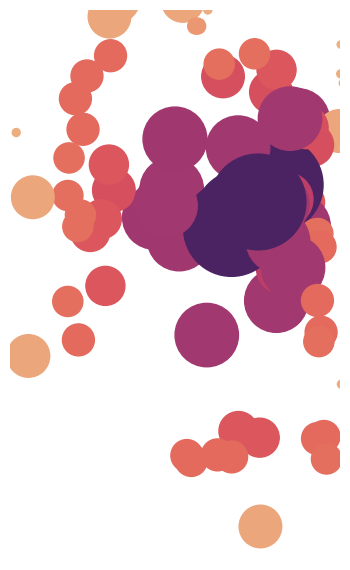

In [238]:
df_inventory = load_cnn_data()
dims = (15, 25);
items, xy = create_initial_plan(
    n_types=15, dims=dims,
    df_inventory=df_inventory[~df_inventory['shade'] & ~df_inventory['moist'] 
                               ],
    )
xy_new = run_gradient_descent(items, df_inventory, dims, xy)


In [ ]:
cols = ['plant', 'dry', 'medium', 'moist', 'sun', 'partial', 'shade','colour','deer resistant']
df_inventory.loc[list(items), cols].value_counts()

In [ ]:
i = ('blue_false_indigo',)
r = df_inventory.loc[list(i)]['diameter'][0] / 2
f, ax = plot_garden(i, np.array([[r, r]]), df_inventory, (2*r, 2*r), 4, False)

In [ ]:

plot_garden(items, xy_new, df_inventory, dims, figsize=10, plot_sideview=True)

In [ ]:
PRETTY_GOOD = (items, xy_new)
plot_garden(items, xy_new, df_inventory, dims, figsize=10, plot_sideview=True)